# Assignment 2 - Calibration and DLT
**Author:** Johannes Holmgren

In [2]:
# Import external modules
# Uncomment below to have interactive 3D models
# %matplotlib widget
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from scipy.linalg import null_space, inv, qr
import cv2
from skimage import transform

# Import internal modules/files
import plotter
import utils

In [3]:
# ----- Constants -----
MAT_PATH = 'data/mat/'      # Path to data
IMG_PATH = 'data/images/'   # Path to images
# ---------------------

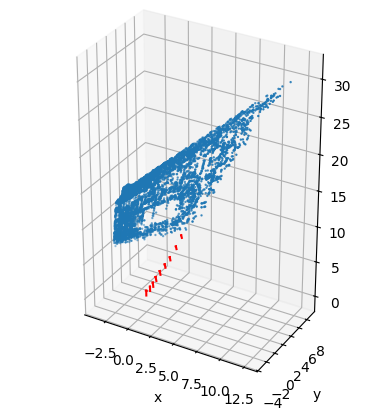

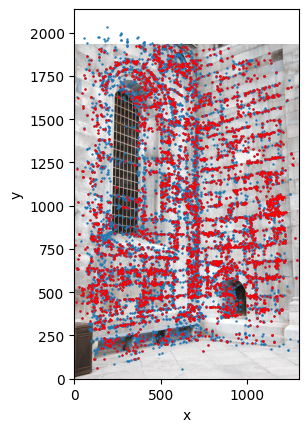

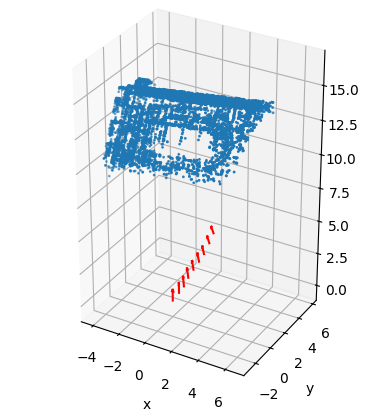

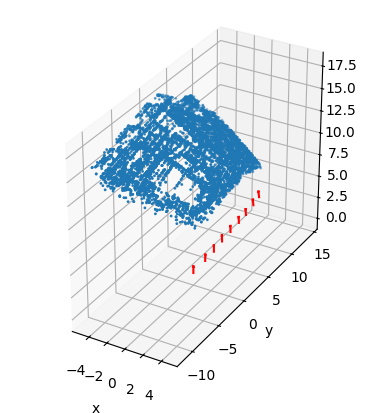

<Axes: xlabel='x', ylabel='y'>

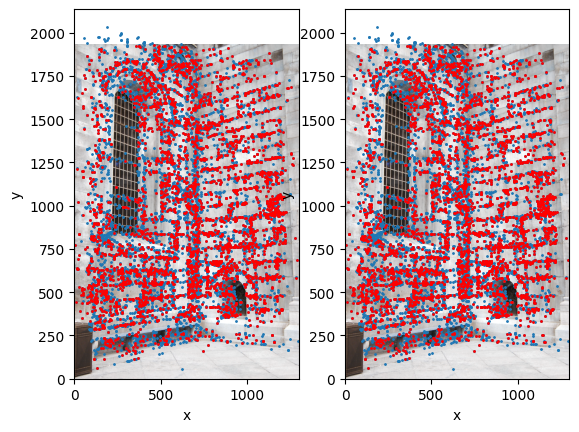

In [6]:
# Computer Exercise 1

# ----- Load data -----
compEx1data = loadmat(MAT_PATH + 'compEx1data.mat')
x       = compEx1data['x'][0]
P       = compEx1data['P'][0]
X       = compEx1data['X']
imfiles = compEx1data['imfiles']
# ---------------------

# ----- Define figure -----
fig = plt.figure()
ax_3D = fig.add_subplot(111, projection='3d')
ax_3D.set_aspect('equal')

# Plot 3D points
plotter.plot_points_3D(ax_3D, X, s=0.5)

# Plot cameras
cameras = [utils.camera_center_and_axis(camera) for camera in P]
centers, axes = map(np.array, zip(*cameras))
plotter.plot_cams(ax_3D, centers, axes, 1)

plt.show()

### Answer to question: No they don't

# Project into Camera 1
CAMERA_INDEX = 0
fig_2D, ax_2D = plt.subplots()
ax_2D.set_aspect('equal')

# Display image
image = cv2.imread(IMG_PATH + imfiles[CAMERA_INDEX][0][0])
ax_2D.imshow(cv2.flip(image, 0))
ax_2D.invert_yaxis()

X_norm = utils.pflat(X)
X_proj = np.matmul(P[CAMERA_INDEX], X_norm)
X_proj_norm = utils.pflat(X_proj)

plotter.plot_points_2D(ax_2D, X_proj_norm, s=0.5, rev=True)
plotter.plot_points_2D(ax_2D, x[CAMERA_INDEX], c='r', s=0.5, rev=True)

plt.show()

### Answer to the questions: Yes the points are very close to each other

T1 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [1/16, 1/16, 0, 1]
])
T2 = np.array([
    [1, 0, 0, 0],
    [0, 3, 0, 0],
    [0, 0, 1, 0],
    [1/9, 1/9, 0, 1]
])

# Transform 3D coordinates using T1 and T2
X_T1 = np.matmul(T1, X_norm)
X_T1_norm = utils.pflat(X_T1)
X_T2 = np.matmul(T2, X_norm)
X_T2_norm = utils.pflat(X_T2)

# Transform cameras by multiplying P*H_inv
P_T1 = np.array([np.matmul(p, inv(T1)) for p in P])
P_T2 = np.array([np.matmul(p, inv(T2)) for p in P])
P_T1_norm = utils.pflat(P_T1)
P_T2_norm = utils.pflat(P_T2)

# Plot T1 Cameras and Points
fig_3D = plt.figure()
ax_3D = fig_3D.add_subplot(projection='3d')
ax_3D.set_aspect('equal')

cameras = [utils.camera_center_and_axis(camera) for camera in P_T1]
centers, axes = map(np.array, zip(*cameras))

plotter.plot_cams(ax_3D, centers, axes, 1)
plotter.plot_points_3D(ax_3D, X_T1_norm)
plt.show()

# Plot T2 Cameras and Points
fig_3D = plt.figure()
ax_3D = fig_3D.add_subplot(projection='3d')
ax_3D.set_aspect('equal')

cameras = [utils.camera_center_and_axis(camera) for camera in P_T2]
centers, axes = map(np.array, zip(*cameras))

plotter.plot_cams(ax_3D, centers, axes, 1)
plotter.plot_points_3D(ax_3D, X_T2_norm)
plt.show()

### Answer to question: Yes, the first transform (T1) looks very reasonable

# Project new 3D points for T1 and T2 onto the transformed camera P1
def project_and_plot(ax, P, Xs, image):
    ''' Project Xs onto P and plot in same figure as image
    
    TBD
    '''
    X_norm = utils.pflat(Xs)
    X_proj = np.matmul(P, X_norm)
    X_proj_norm = utils.pflat(X_proj)
    ax.imshow(cv2.flip(image, 0))
    ax.invert_yaxis()
    plotter.plot_points_2D(ax, X_proj_norm, rev=True)


fig_2D, axs_2D = plt.subplots(1, 2)
axs_2D[0].set_aspect('equal')
axs_2D[1].set_aspect('equal')

# Project points onto each transformed camera
P_T1_1 = P_T1[CAMERA_INDEX]
P_T2_1 = P_T2[CAMERA_INDEX]

project_and_plot(axs_2D[0], P_T1_1, X_T1_norm, image)
project_and_plot(axs_2D[1], P_T2_1, X_T2_norm, image)

# Plot the image points
plotter.plot_points_2D(axs_2D[0], x[CAMERA_INDEX], c='r', rev=True)
plotter.plot_points_2D(axs_2D[1], x[CAMERA_INDEX], c='r', rev=True)

### Answer to question: Both seems to do a proper projection onto the image


1014.8534 839.0383
930.9657 795.186
[[ 0.01  0.   -5.23]
 [ 0.    0.01 -4.28]
 [ 0.    0.    1.  ]]
The standard deviation for image 1 X is 1.0
The standard deviation for image 1 Y is 1.0000000000000002
The standard deviation for image 2 X is 1.0
The standard deviation for image 2 Y is 0.9999999999999996
----- Camera 1 -----
Smallest singular value is 0.05103
||Mv|| =  0.051
----- Camera 2 -----
Smallest singular value is 0.04378
||Mv|| =  0.044
----- Inner parameters for camera 1 -----
Principal point: 	(14.99, 10.61)
Focal length f: 	37.01
Aspect ratio:		1.0
Skew:			-0.0


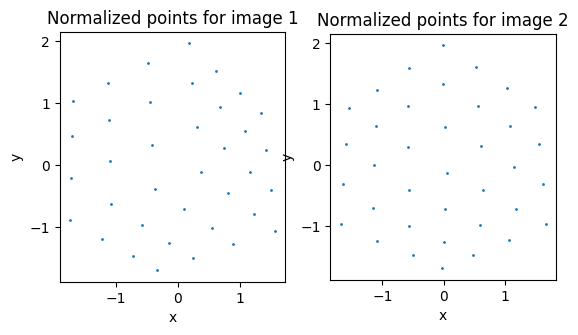

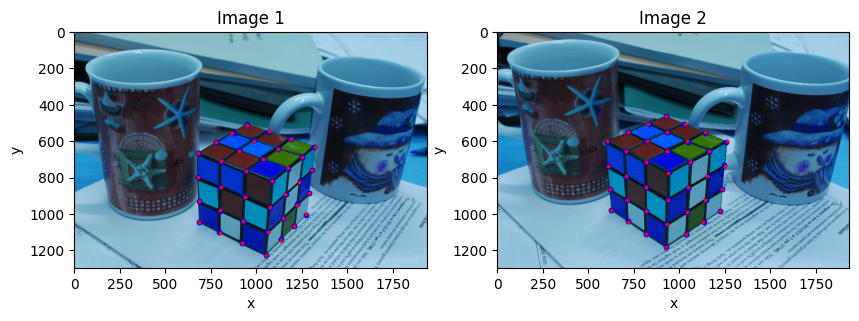

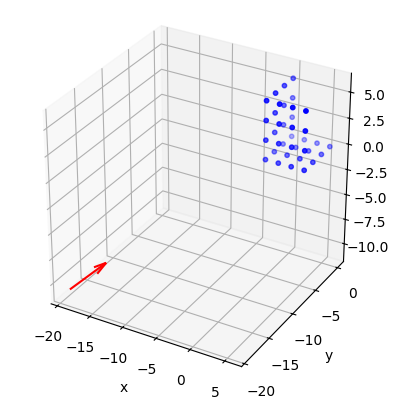

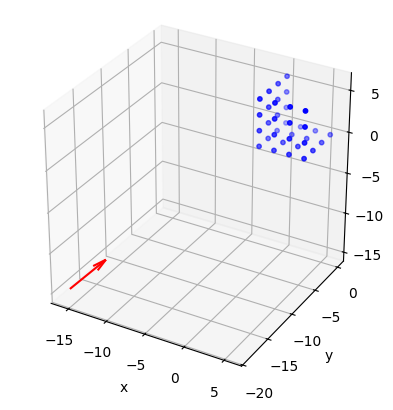

In [14]:
# Computer Exercise 2

def get_normalization_matrix(xs: np.ndarray) -> np.ndarray:
    ''' Get the normalization matrix which subtracts mean and divides by std_dev. 

    Takes the mean and std_dev for x-values and y-values separately.

    Parameters
    ----------
    xs: np.ndarray
        The points to normalize
    
    Returns
    -------
    np.ndarray
        The normalization matrix

    '''
    meanX = np.mean(xs[0])
    meanY = np.mean(xs[1])
    stdX  = np.std(xs[0])
    stdY  = np.std(xs[1])

    print(round(meanX, 4), round(meanY, 4))

    N = np.array([
        [1 / stdX,        0, -meanX / stdX],
        [0,        1 / stdY, -meanY / stdY],
        [0,               0,             1]
    ])
    return N

def estimate_camera_DLT(xs: np.ndarray, Xs: np.ndarray) -> np.ndarray:
    ''' Solve Homogeneous least squares for DLT equations using SVD.

    Used to find the camera matrix P that projects Xs onto xs 
    
    Parameters
    ----------
    xs: np.ndarray
        The projected points onto P

    Xs: np.ndarray
        The 3D model points that was projected

    Returns
    -------
    np.ndarray
        The v-vector from the solution min(||Mv||),
        which contains the camera matrix P as its first 12 elements.
    '''
    # Create M
    nPoints = Xs.shape[1]
    M = np.zeros((2 * nPoints, 12))
    for i, (x, X) in enumerate(zip(xs.T, Xs.T)):
        M[2 * i] = [-X[0], -X[1], -X[2], -X[3], 0, 0, 0, 0, x[0] * X[0], x[0] * X[1], x[0] * X[2], x[0] * X[3]]
        M[2 * i + 1] = [0, 0, 0, 0, -X[0], -X[1], -X[2], -X[3], x[1] * X[0], x[1] * X[1], x[1] * X[2], x[1] * X[3]]
    # Find v as last row of Vh in SVD
    U, S, Vh = np.linalg.svd(M)
    v = Vh[-1]
    # Smallest singular value is given by the last element in S
    sv_min = S[-1]
    return (M, v, sv_min)

def rq(a):
    ''' Performs RQ-factorization on a
    
    Factorizes a matrix 'a' such that a = RQ,
    where R is upper triangular, and Q is a unitary matrix.
    If 'a' is not square, Q is partitioned as Q = [Q1 Q2], where Q1 is unitary.

    Parameters:
    -----------
    a numpy.ndarray: 
        Input matrix (m x n).
        
    Returns:
        r numpy.ndarray: 
            Upper triangular matrix (m x m).
        q numpy.ndarray: 
            Unitary matrix (m x n).

    '''
    m, n = a.shape
    e = np.eye(m)
    # Permutation matrix to reverse rows
    p = e[:, ::-1]
    
    # Perform QR decomposition on the permuted matrix
    q0, r0 = qr(np.dot(p, np.dot(a[:, :m].T, p)))
    
    # Adjust to compute R and Q for the original matrix
    r = np.dot(np.dot(p, r0.T), p)
    q = np.dot(np.dot(p, q0.T), p)
    
    # Fix the signs to ensure R has positive diagonal elements
    fix = np.diag(np.sign(np.diag(r)))
    r = np.dot(r, fix)
    q = np.dot(fix, q)
    
    # Handle the case where the matrix is not square
    if n > m:
        q = np.hstack((q, np.linalg.inv(r) @ a[:, m:n]))
    
    return r, q


# ----- Load data -----
compEx2data = loadmat(MAT_PATH + 'compEx2data.mat')
x2       = compEx2data['x'][0]
Xmodel   = compEx2data['Xmodel']
startind = compEx2data['startind']
endind   = compEx2data['endind']

cube1 = cv2.imread(IMG_PATH + 'cube1.jpg')
cube2 = cv2.imread(IMG_PATH + 'cube2.jpg')

x2_1 = x2[0]
x2_2 = x2[1]

# Convert Xmodel to homogenenous coordinates
Xmodel_hom = np.vstack([Xmodel, np.ones(Xmodel.shape[1]).reshape(1, -1)])
# ---------------------

# Normalize measured points
N1 = get_normalization_matrix(x2_1)
N2 = get_normalization_matrix(x2_2)
x2_1N = np.matmul(N1, x2_1)
x2_2N = np.matmul(N2, x2_2)

print(N1.round(2))

print(f"The standard deviation for image 1 X is {np.std(x2_1N[0])}")
print(f"The standard deviation for image 1 Y is {np.std(x2_1N[1])}")
print(f"The standard deviation for image 2 X is {np.std(x2_2N[0])}")
print(f"The standard deviation for image 2 Y is {np.std(x2_2N[1])}")

# Plot normalized points
fig, axs = plt.subplots(1, 2)
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
plotter.plot_points_2D(axs[0], x2_1N)
plotter.plot_points_2D(axs[1], x2_2N)
axs[0].set_title('Normalized points for image 1')
axs[1].set_title('Normalized points for image 2')

### Answer: The points are centered around 0 with standard deviation 1

# Find v to find min(||Mv||)
M1, v1, sv1_min = estimate_camera_DLT(x2_1N, Xmodel_hom)
M2, v2, sv2_min = estimate_camera_DLT(x2_2N, Xmodel_hom)

print("----- Camera 1 -----")
print("Smallest singular value is", round(sv1_min, 5))
print("||Mv|| = ", round(np.linalg.norm(np.matmul(M1, v1)), 3))

print("----- Camera 2 -----")
print("Smallest singular value is", round(sv2_min, 5))
print("||Mv|| = ", round(np.linalg.norm(np.matmul(M2, v2)), 3))

### Answers: The smallest singular value is close to zero. ||Mv|| is also very close to zero

# Get camera P and test direction
P1_norm = v1[:12].reshape(3, 4)
P2_norm = v2[:12].reshape(3, 4)

# Flip camera if projecting to negative z-values
if np.matmul(P1_norm, Xmodel_hom[:,0])[2] < 0:
    P1_norm *= -1
if np.matmul(P2_norm, Xmodel_hom[:,0])[2] < 0:
    P2_norm *= -1

# Un-normalize camera
P1 = np.matmul(inv(N1), P1_norm)
P2 = np.matmul(inv(N2), P2_norm)

# Plot images, given points and projected points onto the images
fig, axs = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(10)
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')

axs[0].imshow(cube1)
plotter.plot_points_2D(axs[0], x2_1, c='b', s=10)
axs[1].imshow(cube2)
plotter.plot_points_2D(axs[1], x2_2, c='b', s=10)

X_proj_1 = np.matmul(P1, Xmodel_hom)
X_proj_1_norm = utils.pflat(X_proj_1)
X_proj_2 = np.matmul(P2, Xmodel_hom)
X_proj_2_norm = utils.pflat(X_proj_2)

plotter.plot_points_2D(axs[0], X_proj_1_norm, 'r', s=3)
plotter.plot_points_2D(axs[1], X_proj_2_norm, 'r', s=3)

axs[0].set_title('Image 1')
axs[1].set_title('Image 2')

# Make a 3D plot showing the camera and the 3D points
fig_3D = plt.figure()
ax_3D = fig_3D.add_subplot(projection='3d')
ax_3D.set_aspect('equal')
plotter.plot_points_3D(ax_3D, Xmodel_hom, c='b', s=10)
center, axis = utils.camera_center_and_axis(P1)
plotter.plot_camera(ax_3D, center, axis, scale=5)

fig_3D = plt.figure()
ax_3D = fig_3D.add_subplot(projection='3d')
ax_3D.set_aspect('equal')
plotter.plot_points_3D(ax_3D, Xmodel_hom, c='b', s=10)
center, axis = utils.camera_center_and_axis(P2)
plotter.plot_camera(ax_3D, center, axis, scale=5)

### Answers: Yes the plot looks reasonable. Note that the points in the 2D image are plotted upside down
###          and thus the 3D image is flipped in z-direction

# Compute inner parameters of camera 1
a = P1[:,0:-1]
r, q = rq(a)

x0    = r[0, -1]
y0    = r[1, -1]
f     = r[1, 1]
ratio = r[0, 0] / f
skew  = r[0, 1] / f

print("----- Inner parameters for camera 1 -----")
print(f"Principal point: \t({round(x0, 2)}, {round(y0, 2)})")
print(f"Focal length f: \t{round(f, 2)}")
print(f"Aspect ratio:\t\t{round(ratio, 2)}")
print(f"Skew:\t\t\t{round(skew, 2)}")

### Answers: The reason why we know these are true parameters is because we have both the 
###          3D points and their projections, and enough of them are linearly independent 
###          (smallest singular value != 0 and M is of full rank). Thus we have enough points to 
###          set up the SVD matrix to solve for P


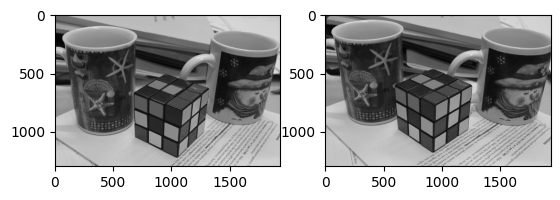

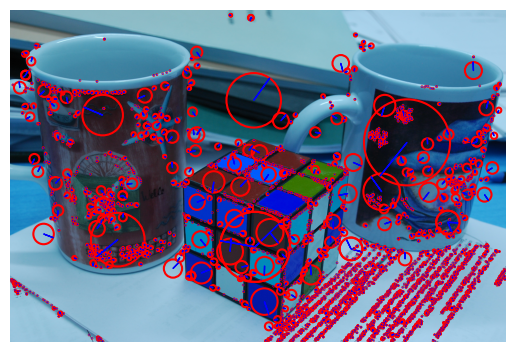

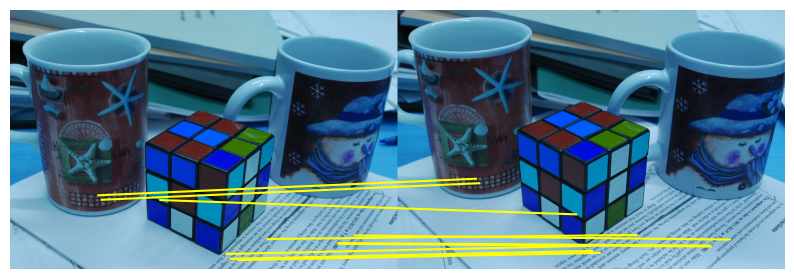

In [ ]:
# Computer Exercise 3
def vl_sift(im):
    # Initialize the SIFT detector
    sift = cv2.SIFT_create(contrastThreshold=0.05)  # 'PeakThresh' in VLFeat is similar to 'contrastThreshold' in OpenCV

    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(im, None)

    # Convert keypoints to a format similar to VLFeat's `f1` matrix
    f = np.array([kp.pt + (kp.size, kp.angle) for kp in keypoints], dtype=np.float32).T  # Each column: [x, y, scale, orientation]
    d = descriptors.T  # SIFT descriptors
    return f, d

def vl_plotframe(im, f):
    # Plot the image
    plt.imshow(im, cmap='gray')
    plt.axis('off')

    # Plot the keypoints
    for x, y, scale, orientation in f.T:  # Each column of f1 corresponds to a keypoint
        # Scale factor for visualization
        radius = scale / 2
        circle = plt.Circle((x, y), radius, color='r', fill=False, linewidth=1.5)
        plt.gca().add_artist(circle)

        # Optional: Add orientation line
        dx = radius * np.cos(orientation)
        dy = radius * np.sin(orientation)
        plt.arrow(x, y, dx, dy, color='b', head_width=0.5, head_length=0.5)

    plt.show()

def vl_ubcmatch(d1, d2):
    # d1 and d2 are the SIFT descriptors from the two images
    # OpenCV FLANN-based matcher
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))

    # Match descriptors using k-nearest neighbors (k=2)
    matches = flann.knnMatch(d1.T, d2.T, k=2)  # Transpose descriptors to match OpenCV's format

    # Apply the Lowe's ratio test
    good_matches = []
    scores = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:  # Adjust the ratio as needed
            good_matches.append((m.queryIdx, m.trainIdx))
            scores.append(m.distance)

    # Convert matches and scores to NumPy arrays for easier manipulation
    matches = np.array(good_matches).T  # Shape: (2, num_matches)
    scores = np.array(scores)

    return matches, scores

# ----- Load data -----
im1 = cv2.imread(IMG_PATH + 'cube1.jpg')
im2 = cv2.imread(IMG_PATH + 'cube2.jpg')

# Convert to grayscale
gray_im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
gray_im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
# ---------------------

""" # Blur images to get rid of small details (text)
gray_im1_blur = cv2.GaussianBlur(gray_im1, (11, 11), 1.7)
gray_im2_blur = cv2.GaussianBlur(gray_im2, (11, 11), 1.7) """

fig, axs = plt.subplots(1, 2)
axs[0].imshow(gray_im1, cmap='gray')
axs[1].imshow(gray_im2, cmap='gray')
plt.show()

# Get features
f1, d1 = vl_sift(gray_im1)
f2, d2 = vl_sift(gray_im2)

# Plot features with image
vl_plotframe(im1, f1)

# Match descriptors for the two images
matches, scores = vl_ubcmatch(d1, d2)

# Extract matching points
x1 = f1[:2, matches[0, :]]  # First two rows (x, y) from f1 for matched indices
x2 = f2[:2, matches[1, :]]  # First two rows (x, y) from f2 for matched indices

# Randomly select 10 points and plot lines between points
perm = np.random.permutation(matches.shape[1])

# Concatenate images side by side
concatenated_image = np.concatenate((im1, im2), axis=1)

# Display the concatenated image
plt.figure(figsize=(10, 5))
plt.imshow(concatenated_image, cmap='gray')
plt.axis('off')

# Select 10 random matches from the permutation
num_matches_to_plot = 10
selected_indices = perm[:num_matches_to_plot]

# Plot the matched points
for idx in selected_indices:
    # Coordinates in the first image
    x1_x, x1_y = x1[0, idx], x1[1, idx]
    # Coordinates in the second image (shifted by im1's width)
    x2_x, x2_y = x2[0, idx] + im1.shape[1], x2[1, idx]
    
    # Plot a line connecting the matched points
    plt.plot([x1_x, x2_x], [x1_y, x2_y], '-', linewidth=1.5, color='yellow')

plt.show()

### Answers: A lot of matches on the text, which seems to be correct in 
###          some cases but other it's not / diffcult to say.


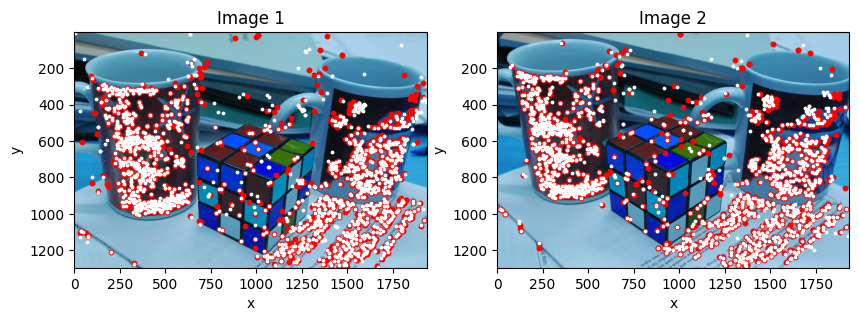

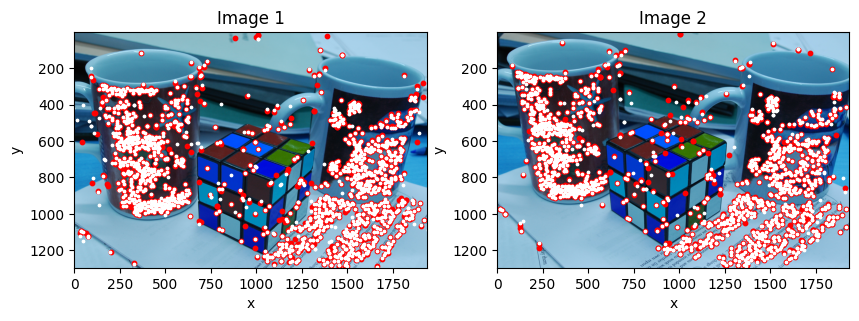

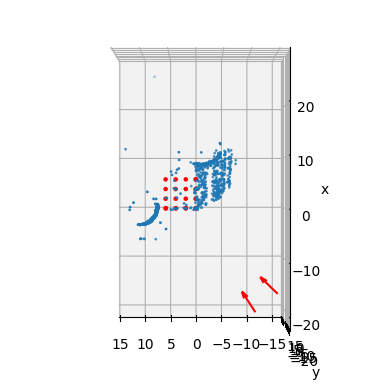

In [ ]:
# Computer Exercise 4

def triangulate_3D_point_DLT(xs1: np.ndarray, xs2: np.ndarray, P1: np.ndarray, P2: np.ndarray) -> np.ndarray:
    ''' Triangulate 3D points X projected into x1 and x2 using P1 and P2.

    Parameters
    ----------
    xs1: np.ndarray
        X projected into P1 in homogenenous coordinates

    xs2: np.ndarray
        X projected into P2 in homogenenous coordinates

    P1: np.ndarray
        Camera 1
    
    P2: np.ndarray
        Camera 2

    Returns
    -------
    np.ndarray
        The triangulated 3D points in homogenenous coordinates

    '''
    Xs = []
    for x1, x2 in zip(xs1.T, xs2.T):
        M = np.concat([
            np.concat([P1, x1.reshape(-1, 1), np.zeros((x1.shape[0], 1))], axis=1),
            np.concat([P2, np.zeros((x1.shape[0], 1)), x2.reshape(-1, 1)], axis=1)
        ])
        U, S, Vh = np.linalg.svd(M)
        v = Vh[-1]
        Xs.append(v[:4])
    Xs = np.array(Xs).T
    Xs = utils.pflat(Xs)
    return Xs

# ----- Data (from previous exercises) -----
x1toEx5 = loadmat(MAT_PATH + 'x1toEx5.mat')
x2toEx5 = loadmat(MAT_PATH + 'x2toEx5.mat')
x1 = x1toEx5['x1']
x2 = x2toEx5['x2']
P1 : np.ndarray
P2 : np.ndarray
cube1 : np.ndarray
cube2 : np.ndarray
# ------------------------------------------
x1_hom = np.concat([x1, np.ones((1, x1.shape[1]))])
x2_hom = np.concat([x2, np.ones((1, x2.shape[1]))])

#----- Project and plot the computed points onto the images -----

# Get 3D points
Xs = triangulate_3D_point_DLT(x1_hom, x2_hom, P1, P2)

# Project points
X_proj_1 = np.matmul(P1, Xs)
X_proj_1_norm = utils.pflat(X_proj_1)
X_proj_2 = np.matmul(P2, Xs)
X_proj_2_norm = utils.pflat(X_proj_2)

# Setup figure
fig, axs = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(10)
axs[0].set_xlim(0, cube1.shape[1])
axs[1].set_xlim(0, cube2.shape[1])
axs[0].set_ylim(cube1.shape[0])
axs[1].set_ylim(cube2.shape[0])
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')

# Plot images
axs[0].imshow(cube1)
axs[1].imshow(cube2)

# Plot points obtained from SIFT
plotter.plot_points_2D(axs[0], x1, c='r', s=10)
plotter.plot_points_2D(axs[1], x2, c='r', s=10)

# Plot projected points
plotter.plot_points_2D(axs[0], X_proj_1_norm, c='w', s=3)
plotter.plot_points_2D(axs[1], X_proj_2_norm, c='w', s=3)

axs[0].set_title('Image 1')
axs[1].set_title('Image 2')

#----- Rerun the triangulation using normalized cameras -----

# Get K
K1, _ = rq(P1[:,0:3])
K2, _ = rq(P2[:,0:3])

# Normalize Cameras
P1_norm = np.matmul(inv(K1), P1)
P2_norm = np.matmul(inv(K2), P2)

# Normalize 2D points
x1_norm = np.matmul(inv(K1), x1_hom)
x2_norm = np.matmul(inv(K2), x2_hom)

# Get triangulated points
Xs_norm = triangulate_3D_point_DLT(x1_norm, x2_norm, P1_norm, P2_norm)

# Project points
X_proj_1 = np.matmul(P1, Xs_norm)
X_proj_1_norm = utils.pflat(X_proj_1)
X_proj_2 = np.matmul(P2, Xs_norm)
X_proj_2_norm = utils.pflat(X_proj_2)

# Setup figure
fig, axs = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(10)
axs[0].set_xlim(0, cube1.shape[1])
axs[1].set_xlim(0, cube2.shape[1])
axs[0].set_ylim(cube1.shape[0])
axs[1].set_ylim(cube2.shape[0])
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')

# Plot images
axs[0].imshow(cube1)
axs[1].imshow(cube2)

# Plot points obtained from SIFT
plotter.plot_points_2D(axs[0], x1, c='r', s=10)
plotter.plot_points_2D(axs[1], x2, c='r', s=10)

# Plot projected points
plotter.plot_points_2D(axs[0], X_proj_1_norm, c='w', s=3)
plotter.plot_points_2D(axs[1], X_proj_2_norm, c='w', s=3)

axs[0].set_title('Image 1')
axs[1].set_title('Image 2')

#----- Remove points with high pixel errors -----
EPS = 3
n_points = x1.shape[1]

mask = np.ones(n_points)
for i in range(n_points):
    if np.linalg.norm(X_proj_1_norm[:-1, i] - x1[:,i]) > EPS:
        mask[i] = 0
    if np.linalg.norm(X_proj_2_norm[:-1, i] - x2[:,i]) > EPS:
        mask[i] = 0

mask = (
    (np.linalg.norm(x1 - X_proj_1_norm[:-1,:], axis=0) < 3)
    &
    (np.linalg.norm(x2 - X_proj_2_norm[:-1,:], axis=0) < 3)
)


X_new = Xs_norm[:,mask.astype(bool)]

# Plot new 3D points
fig_3D = plt.figure()
ax_3D = fig_3D.add_subplot(projection='3d')

plotter.plot_points_3D(ax_3D, X_new, s=1)
plotter.plot_points_3D(ax_3D, Xmodel_hom, c='r', s=5)

center_1, axis_1 = utils.camera_center_and_axis(P1)
center_2, axis_2 = utils.camera_center_and_axis(P2)

plotter.plot_camera(ax_3D, center_1, axis_1, scale=5)
plotter.plot_camera(ax_3D, center_2, axis_2, scale=5)

ax_3D.view_init(elev=-180, azim=90, roll=270)

#----- Show everything -----
plt.show()
